In [2]:
import os

In [3]:
import zipfile

In [28]:
os.listdir('./aug_train1')

['1gr', '2gr', '3gr']

In [29]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [30]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

In [31]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

In [35]:
!pip install h5py scikit-optimize

keras-applications 1.0.2 has requirement keras>=2.1.6, but you'll have keras 2.1.3 which is incompatible.
keras-preprocessing 1.0.1 has requirement keras>=2.1.6, but you'll have keras 2.1.3 which is incompatible.


In [32]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args


In [33]:
datagen_train = ImageDataGenerator(
      rescale=1./128)

In [34]:
datagen_test = ImageDataGenerator(rescale=1./128)

In [35]:
epochs=2
batch_size = 10
steps_per_epoch_train=9000//10
steps_per_epoch_val=152//10


In [52]:
generator_train.reset()
generator_train = datagen_train.flow_from_directory(directory='./aug_train1',
                               
                                                    target_size=(224,224),
                                                    batch_size=10,
                                                    class_mode='categorical',shuffle=True)

Found 9000 images belonging to 3 classes.


In [53]:
generator_test.reset()
generator_test = datagen_test.flow_from_directory(directory='./valid1',
                                                  target_size=(224,224),
                                                  batch_size=10,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 152 images belonging to 3 classes.


In [38]:
steps_test = generator_test.n / batch_size
steps_test

15.2

In [39]:
from sklearn.utils.class_weight import compute_class_weight

In [40]:
cls_train = generator_train.classes


In [41]:
cls_test = generator_test.classes

In [42]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(cls_train), y=cls_train)

In [43]:
class_weight

array([ 1.,  1.,  1.])

In [44]:
# 가우시안 프로세스를 이용한 Bayesian optimizer를 위한 scikit-optimizer 사용
dim_learning_rate=Real(low=1e-7, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers=Integer(low=1, high=3, name='num_dense_layers')
dim_num_dense_nodes=Integer(low=5, high=1024, name='num_dense_nodes')
dim_num_epoch=Integer(low=1,high=20,name='num_epoch')

In [45]:
dimensions = [dim_learning_rate, dim_num_dense_layers, dim_num_dense_nodes, dim_num_epoch]

In [46]:
default_parameters = [1e-5, 1, 16, 1]

In [47]:
def create_model(learning_rate, num_dense_layers, num_dense_nodes, num_epoch):
  model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
  transfer_layer = model.get_layer('block5_pool')
  
  conv_model = Model(inputs=model.input, outputs=transfer_layer.output)
  for layer in conv_model.layers:
    layer.trainable = False
  
  new_model = Sequential()
  new_model.add(conv_model)
  new_model.add(Flatten())
  for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    new_model.add(Dense(num_dense_nodes, activation='relu', name=name))
  new_model.add(Dense(3, activation='softmax'))
  optimizer=Adam(lr=learning_rate)
  new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  
 
  
  return new_model

In [48]:
path_best_model = './300aug_vgg16_best.1'
best_accuracy = 0.0

In [61]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, num_epoch):
  print('learning rate: {0:.1e}'.format(learning_rate))
  print('num_dense_layers:', num_dense_layers)
  print('num_dense_nodes:', num_dense_nodes)
  print('num_epoch:', num_epoch)
  
  print()
  
  new_model = create_model(learning_rate=learning_rate, num_dense_layers=num_dense_layers, num_dense_nodes=num_dense_nodes, num_epoch=num_epoch)
  history = new_model.fit_generator(generator=generator_train,
                                  epochs=num_epoch,
                                  steps_per_epoch=steps_per_epoch_train,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_per_epoch_val)
  
  accuracy = history.history['val_acc'][-1]
  print()
  print("Accuracy: {0:.2%}".format(accuracy))
  print()
  
  global best_accuracy
  
  if accuracy > best_accuracy:
    new_model.save(path_best_model)
    best_accuracy = accuracy
  fig, loss_ax = plt.subplots()

  acc_ax = loss_ax.twinx()

  loss_ax.plot(history.history['loss'], 'y', label='train loss')
  loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

  acc_ax.plot(history.history['acc'], 'b', label='train acc')
  acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

  loss_ax.set_xlabel('Epochs')
  loss_ax.set_ylabel('Loss')
  acc_ax.set_ylabel('Accuracy')

  loss_ax.legend(loc='upper right')
  acc_ax.legend(loc='lower right')
  plt.title("Best model neural network train and validation")

  plt.show()

  generator_train.reset()
  generator_test.reset()
  del new_model
  K.clear_session()
  return -accuracy

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 57s 63ms/step - loss: 0.8000 - acc: 0.7994 - val_loss: 0.6494 - val_acc: 0.7800

Accuracy: 78.00%



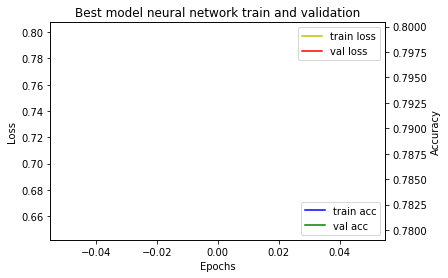

learning rate: 6.9e-06
num_dense_layers: 1
num_dense_nodes: 839
num_epoch: 3

Epoch 1/3
900/900 [==============================] - 68s 75ms/step - loss: 0.3466 - acc: 0.9273 - val_loss: 0.3973 - val_acc: 0.8400
Epoch 2/3
900/900 [==============================] - 68s 75ms/step - loss: 0.0855 - acc: 0.9919 - val_loss: 0.4160 - val_acc: 0.8310
Epoch 3/3
900/900 [==============================] - 68s 76ms/step - loss: 0.0440 - acc: 0.9951 - val_loss: 0.3347 - val_acc: 0.8732

Accuracy: 87.32%



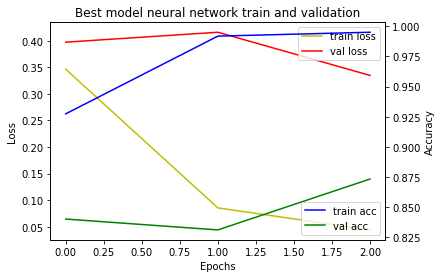

learning rate: 2.4e-07
num_dense_layers: 3
num_dense_nodes: 714
num_epoch: 9

Epoch 1/9
900/900 [==============================] - 68s 76ms/step - loss: 1.0297 - acc: 0.5984 - val_loss: 0.9878 - val_acc: 0.5067
Epoch 2/9
900/900 [==============================] - 68s 75ms/step - loss: 0.8728 - acc: 0.8437 - val_loss: 0.8491 - val_acc: 0.8169
Epoch 3/9
900/900 [==============================] - 68s 75ms/step - loss: 0.7527 - acc: 0.8927 - val_loss: 0.7233 - val_acc: 0.8592
Epoch 4/9
900/900 [==============================] - 68s 75ms/step - loss: 0.6510 - acc: 0.9248 - val_loss: 0.6588 - val_acc: 0.8310
Epoch 5/9
900/900 [==============================] - 68s 75ms/step - loss: 0.5658 - acc: 0.9410 - val_loss: 0.6351 - val_acc: 0.7958
Epoch 6/9
900/900 [==============================] - 68s 75ms/step - loss: 0.4951 - acc: 0.9551 - val_loss: 0.5490 - val_acc: 0.8451
Epoch 7/9
900/900 [==============================] - 68s 76ms/step - loss: 0.4360 - acc: 0.9623 - val_loss: 0.5242 - val_acc

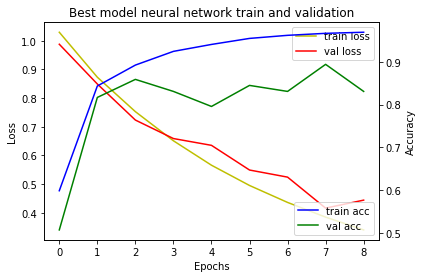

learning rate: 2.8e-07
num_dense_layers: 2
num_dense_nodes: 324
num_epoch: 7

Epoch 1/7
900/900 [==============================] - 61s 68ms/step - loss: 1.0427 - acc: 0.5703 - val_loss: 0.9796 - val_acc: 0.7200
Epoch 2/7
900/900 [==============================] - 61s 67ms/step - loss: 0.8910 - acc: 0.7983 - val_loss: 0.8975 - val_acc: 0.6408
Epoch 3/7
900/900 [==============================] - 61s 67ms/step - loss: 0.7819 - acc: 0.8692 - val_loss: 0.7598 - val_acc: 0.8521
Epoch 4/7
900/900 [==============================] - 61s 68ms/step - loss: 0.6915 - acc: 0.8973 - val_loss: 0.6988 - val_acc: 0.8592
Epoch 5/7
900/900 [==============================] - 61s 67ms/step - loss: 0.6188 - acc: 0.9179 - val_loss: 0.6811 - val_acc: 0.8099
Epoch 6/7
900/900 [==============================] - 61s 67ms/step - loss: 0.5571 - acc: 0.9361 - val_loss: 0.6123 - val_acc: 0.8310
Epoch 7/7
900/900 [==============================] - 61s 68ms/step - loss: 0.5046 - acc: 0.9510 - val_loss: 0.5694 - val_acc

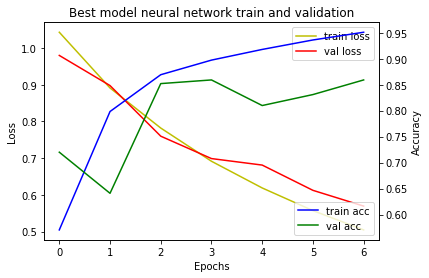

learning rate: 7.5e-07
num_dense_layers: 2
num_dense_nodes: 774
num_epoch: 10

Epoch 1/10
900/900 [==============================] - 67s 75ms/step - loss: 0.8687 - acc: 0.7660 - val_loss: 0.6955 - val_acc: 0.8200
Epoch 2/10
900/900 [==============================] - 67s 74ms/step - loss: 0.5621 - acc: 0.9324 - val_loss: 0.5743 - val_acc: 0.8310
Epoch 3/10
900/900 [==============================] - 67s 74ms/step - loss: 0.3946 - acc: 0.9638 - val_loss: 0.4770 - val_acc: 0.8592
Epoch 4/10
900/900 [==============================] - 67s 75ms/step - loss: 0.2870 - acc: 0.9754 - val_loss: 0.4320 - val_acc: 0.8380
Epoch 5/10
900/900 [==============================] - 68s 75ms/step - loss: 0.2143 - acc: 0.9803 - val_loss: 0.4019 - val_acc: 0.8380
Epoch 6/10
900/900 [==============================] - 67s 75ms/step - loss: 0.1636 - acc: 0.9850 - val_loss: 0.3822 - val_acc: 0.8310
Epoch 7/10
900/900 [==============================] - 68s 75ms/step - loss: 0.1275 - acc: 0.9878 - val_loss: 0.3566 -

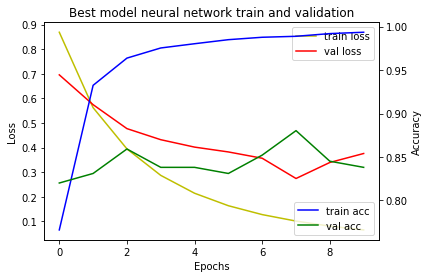

learning rate: 1.4e-06
num_dense_layers: 1
num_dense_nodes: 335
num_epoch: 5

Epoch 1/5
900/900 [==============================] - 60s 67ms/step - loss: 0.8112 - acc: 0.7621 - val_loss: 0.6825 - val_acc: 0.8067
Epoch 2/5
900/900 [==============================] - 60s 67ms/step - loss: 0.4842 - acc: 0.9384 - val_loss: 0.5418 - val_acc: 0.8451
Epoch 3/5
900/900 [==============================] - 60s 67ms/step - loss: 0.3355 - acc: 0.9696 - val_loss: 0.4481 - val_acc: 0.8592
Epoch 4/5
900/900 [==============================] - 60s 67ms/step - loss: 0.2500 - acc: 0.9790 - val_loss: 0.4248 - val_acc: 0.8521
Epoch 5/5
900/900 [==============================] - 60s 67ms/step - loss: 0.1931 - acc: 0.9824 - val_loss: 0.4204 - val_acc: 0.8521

Accuracy: 85.21%



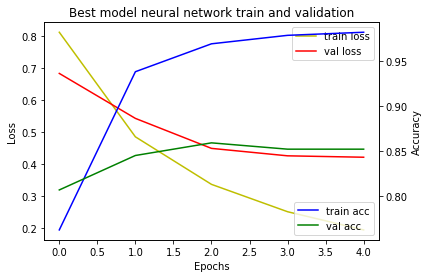

learning rate: 9.8e-05
num_dense_layers: 3
num_dense_nodes: 577
num_epoch: 10

Epoch 1/10
900/900 [==============================] - 65s 72ms/step - loss: 0.1383 - acc: 0.9472 - val_loss: 0.5389 - val_acc: 0.8400
Epoch 2/10
900/900 [==============================] - 65s 72ms/step - loss: 0.0248 - acc: 0.9902 - val_loss: 0.5686 - val_acc: 0.8380
Epoch 3/10
900/900 [==============================] - 65s 72ms/step - loss: 0.0341 - acc: 0.9897 - val_loss: 0.4480 - val_acc: 0.8873
Epoch 4/10
900/900 [==============================] - 65s 72ms/step - loss: 0.0169 - acc: 0.9961 - val_loss: 0.4399 - val_acc: 0.8521
Epoch 5/10
900/900 [==============================] - 65s 72ms/step - loss: 0.0148 - acc: 0.9952 - val_loss: 0.5526 - val_acc: 0.8310
Epoch 6/10
900/900 [==============================] - 65s 72ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.8115 - val_acc: 0.7958
Epoch 7/10
900/900 [==============================] - 65s 72ms/step - loss: 0.0072 - acc: 0.9976 - val_loss: 0.6023 -

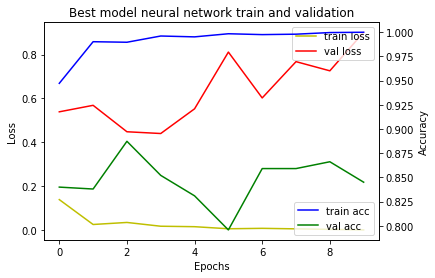

learning rate: 5.1e-06
num_dense_layers: 3
num_dense_nodes: 10
num_epoch: 17

Epoch 1/17
900/900 [==============================] - 57s 64ms/step - loss: 0.9581 - acc: 0.5396 - val_loss: 0.7073 - val_acc: 0.8200
Epoch 2/17
900/900 [==============================] - 57s 64ms/step - loss: 0.7405 - acc: 0.6536 - val_loss: 0.6167 - val_acc: 0.8451
Epoch 3/17
900/900 [==============================] - 57s 64ms/step - loss: 0.6390 - acc: 0.6822 - val_loss: 0.5087 - val_acc: 0.8521
Epoch 4/17
900/900 [==============================] - 58s 65ms/step - loss: 0.5605 - acc: 0.7756 - val_loss: 0.4678 - val_acc: 0.8380
Epoch 5/17
900/900 [==============================] - 58s 64ms/step - loss: 0.4904 - acc: 0.8809 - val_loss: 0.4246 - val_acc: 0.8521
Epoch 6/17
900/900 [==============================] - 58s 64ms/step - loss: 0.4237 - acc: 0.9444 - val_loss: 0.3838 - val_acc: 0.8873
Epoch 7/17
900/900 [==============================] - 58s 65ms/step - loss: 0.3592 - acc: 0.9730 - val_loss: 0.3352 - 

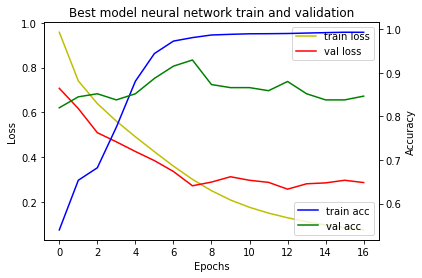

learning rate: 9.6e-03
num_dense_layers: 2
num_dense_nodes: 225
num_epoch: 10

Epoch 1/10
900/900 [==============================] - 60s 66ms/step - loss: 10.7381 - acc: 0.3329 - val_loss: 13.9690 - val_acc: 0.1333
Epoch 2/10
900/900 [==============================] - 59s 66ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 3/10
900/900 [==============================] - 60s 66ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 4/10
900/900 [==============================] - 60s 67ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 5/10
900/900 [==============================] - 60s 67ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 6/10
900/900 [==============================] - 60s 67ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 7/10
900/900 [==============================] - 60s 67ms/step - loss: 10.7454 - acc: 0.3333 - val_l

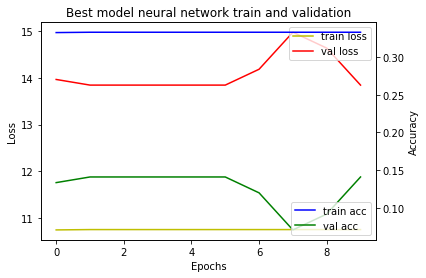

learning rate: 1.5e-05
num_dense_layers: 1
num_dense_nodes: 840
num_epoch: 4

Epoch 1/4
900/900 [==============================] - 67s 75ms/step - loss: 0.2146 - acc: 0.9543 - val_loss: 0.3750 - val_acc: 0.8400
Epoch 2/4
900/900 [==============================] - 67s 74ms/step - loss: 0.0410 - acc: 0.9950 - val_loss: 0.4185 - val_acc: 0.8451
Epoch 3/4
900/900 [==============================] - 67s 75ms/step - loss: 0.0221 - acc: 0.9971 - val_loss: 0.3973 - val_acc: 0.8662
Epoch 4/4
900/900 [==============================] - 67s 75ms/step - loss: 0.0132 - acc: 0.9980 - val_loss: 0.5123 - val_acc: 0.8592

Accuracy: 85.92%



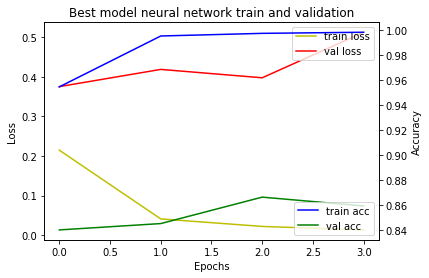

learning rate: 4.6e-06
num_dense_layers: 2
num_dense_nodes: 351
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 61s 68ms/step - loss: 0.5213 - acc: 0.8958 - val_loss: 0.4625 - val_acc: 0.8333
Epoch 2/20
900/900 [==============================] - 61s 68ms/step - loss: 0.1679 - acc: 0.9839 - val_loss: 0.3992 - val_acc: 0.8310
Epoch 3/20
900/900 [==============================] - 61s 68ms/step - loss: 0.0804 - acc: 0.9916 - val_loss: 0.2982 - val_acc: 0.8662
Epoch 4/20
900/900 [==============================] - 61s 68ms/step - loss: 0.0470 - acc: 0.9939 - val_loss: 0.3827 - val_acc: 0.8380
Epoch 5/20
900/900 [==============================] - 61s 68ms/step - loss: 0.0315 - acc: 0.9946 - val_loss: 0.4225 - val_acc: 0.8310
Epoch 6/20
900/900 [==============================] - 61s 68ms/step - loss: 0.0219 - acc: 0.9963 - val_loss: 0.4364 - val_acc: 0.8310
Epoch 7/20
900/900 [==============================] - 62s 68ms/step - loss: 0.0157 - acc: 0.9980 - val_loss: 0.4032 -

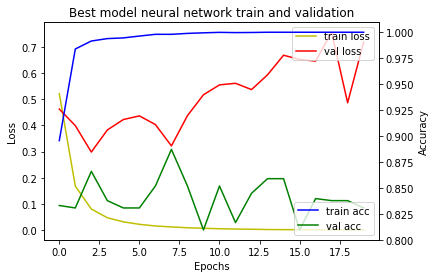

learning rate: 2.0e-05
num_dense_layers: 3
num_dense_nodes: 1024
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 72s 80ms/step - loss: 0.1635 - acc: 0.9510 - val_loss: 0.4786 - val_acc: 0.8467

Accuracy: 84.67%



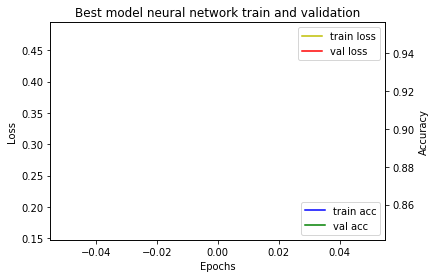

learning rate: 1.0e-07
num_dense_layers: 1
num_dense_nodes: 5
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 56s 63ms/step - loss: 1.0969 - acc: 0.3422 - val_loss: 1.0864 - val_acc: 0.3400
Epoch 2/20
900/900 [==============================] - 56s 62ms/step - loss: 1.0866 - acc: 0.3684 - val_loss: 1.0767 - val_acc: 0.4225
Epoch 3/20
900/900 [==============================] - 56s 63ms/step - loss: 1.0803 - acc: 0.3889 - val_loss: 1.0579 - val_acc: 0.5070
Epoch 4/20
900/900 [==============================] - 56s 62ms/step - loss: 1.0753 - acc: 0.4010 - val_loss: 1.0526 - val_acc: 0.5493
Epoch 5/20
900/900 [==============================] - 56s 62ms/step - loss: 1.0705 - acc: 0.4080 - val_loss: 1.0452 - val_acc: 0.5845
Epoch 6/20
900/900 [==============================] - 56s 62ms/step - loss: 1.0658 - acc: 0.4127 - val_loss: 1.0389 - val_acc: 0.5634
Epoch 7/20
900/900 [==============================] - 56s 62ms/step - loss: 1.0612 - acc: 0.4110 - val_loss: 1.0341 - v

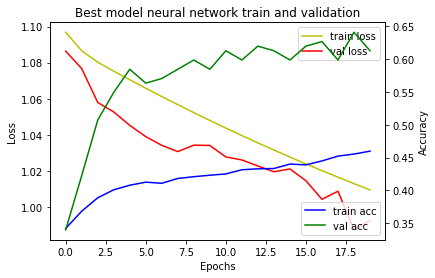

learning rate: 1.0e-07
num_dense_layers: 3
num_dense_nodes: 1024
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 72s 80ms/step - loss: 1.0816 - acc: 0.5391 - val_loss: 0.9838 - val_acc: 0.7933

Accuracy: 79.33%



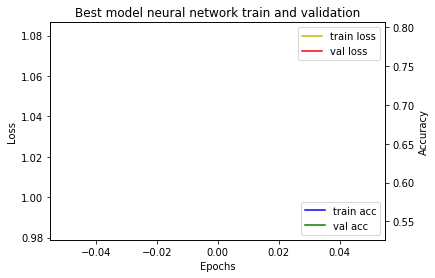

learning rate: 4.0e-05
num_dense_layers: 3
num_dense_nodes: 1024
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 72s 80ms/step - loss: 0.1225 - acc: 0.9592 - val_loss: 0.6396 - val_acc: 0.8400
Epoch 2/20
900/900 [==============================] - 71s 79ms/step - loss: 0.0220 - acc: 0.9934 - val_loss: 0.7539 - val_acc: 0.8521
Epoch 3/20
900/900 [==============================] - 72s 80ms/step - loss: 0.0221 - acc: 0.9927 - val_loss: 0.4623 - val_acc: 0.8592
Epoch 4/20
900/900 [==============================] - 72s 80ms/step - loss: 0.0139 - acc: 0.9954 - val_loss: 0.8706 - val_acc: 0.8592
Epoch 5/20
900/900 [==============================] - 72s 80ms/step - loss: 0.0046 - acc: 0.9983 - val_loss: 1.1179 - val_acc: 0.8592
Epoch 6/20
900/900 [==============================] - 72s 80ms/step - loss: 0.0085 - acc: 0.9961 - val_loss: 0.9465 - val_acc: 0.8380
Epoch 7/20
900/900 [==============================] - 72s 80ms/step - loss: 0.0050 - acc: 0.9983 - val_loss: 0.7109 

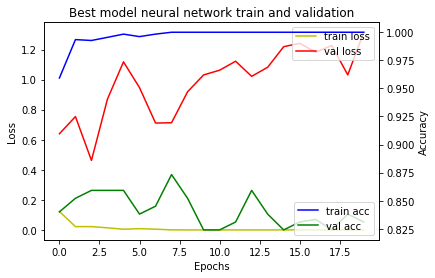

learning rate: 6.6e-06
num_dense_layers: 3
num_dense_nodes: 1024
num_epoch: 10

Epoch 1/10
900/900 [==============================] - 72s 80ms/step - loss: 0.3059 - acc: 0.9211 - val_loss: 0.3711 - val_acc: 0.8400
Epoch 2/10
900/900 [==============================] - 71s 79ms/step - loss: 0.0365 - acc: 0.9930 - val_loss: 0.4361 - val_acc: 0.8451
Epoch 3/10
900/900 [==============================] - 71s 79ms/step - loss: 0.0169 - acc: 0.9961 - val_loss: 0.3479 - val_acc: 0.8380
Epoch 4/10
900/900 [==============================] - 71s 79ms/step - loss: 0.0083 - acc: 0.9988 - val_loss: 0.5689 - val_acc: 0.8380
Epoch 5/10
900/900 [==============================] - 71s 79ms/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.6185 - val_acc: 0.8592
Epoch 6/10
900/900 [==============================] - 72s 80ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.6347 - val_acc: 0.8028
Epoch 7/10
900/900 [==============================] - 72s 80ms/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.5463 

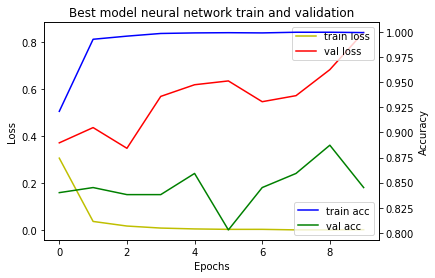

learning rate: 4.4e-05
num_dense_layers: 1
num_dense_nodes: 5
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 58s 64ms/step - loss: 0.6886 - acc: 0.6759 - val_loss: 0.5348 - val_acc: 0.7933
Epoch 2/20
900/900 [==============================] - 57s 64ms/step - loss: 0.4112 - acc: 0.9247 - val_loss: 0.3946 - val_acc: 0.8732
Epoch 3/20
900/900 [==============================] - 58s 64ms/step - loss: 0.2617 - acc: 0.9664 - val_loss: 0.2750 - val_acc: 0.8732
Epoch 4/20
900/900 [==============================] - 56s 63ms/step - loss: 0.1728 - acc: 0.9768 - val_loss: 0.2745 - val_acc: 0.8662
Epoch 5/20
900/900 [==============================] - 56s 63ms/step - loss: 0.1210 - acc: 0.9808 - val_loss: 0.2834 - val_acc: 0.8662
Epoch 6/20
900/900 [==============================] - 56s 63ms/step - loss: 0.0893 - acc: 0.9870 - val_loss: 0.2949 - val_acc: 0.8380
Epoch 7/20
900/900 [==============================] - 56s 63ms/step - loss: 0.0679 - acc: 0.9901 - val_loss: 0.2750 - v

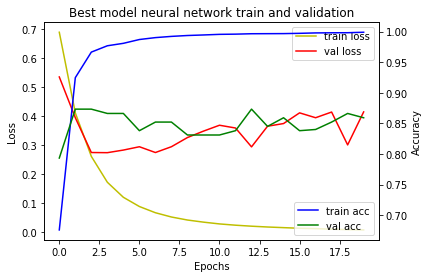

learning rate: 5.1e-07
num_dense_layers: 3
num_dense_nodes: 1024
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 72s 80ms/step - loss: 0.9302 - acc: 0.7231 - val_loss: 0.7664 - val_acc: 0.8533

Accuracy: 85.33%



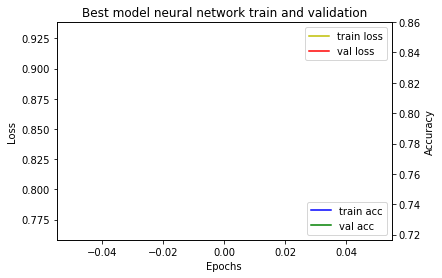

learning rate: 2.8e-05
num_dense_layers: 1
num_dense_nodes: 1024
num_epoch: 11

Epoch 1/11
900/900 [==============================] - 70s 78ms/step - loss: 0.1602 - acc: 0.9609 - val_loss: 0.4346 - val_acc: 0.8267
Epoch 2/11
900/900 [==============================] - 70s 77ms/step - loss: 0.0263 - acc: 0.9954 - val_loss: 0.5523 - val_acc: 0.8310
Epoch 3/11
900/900 [==============================] - 70s 77ms/step - loss: 0.0121 - acc: 0.9976 - val_loss: 0.4363 - val_acc: 0.8380
Epoch 4/11
900/900 [==============================] - 70s 77ms/step - loss: 0.0063 - acc: 0.9997 - val_loss: 0.5771 - val_acc: 0.8380
Epoch 5/11
900/900 [==============================] - 70s 77ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.6787 - val_acc: 0.8380
Epoch 6/11
900/900 [==============================] - 70s 77ms/step - loss: 0.0020 - acc: 0.9999 - val_loss: 0.7243 - val_acc: 0.8380
Epoch 7/11
900/900 [==============================] - 70s 77ms/step - loss: 0.0037 - acc: 0.9991 - val_loss: 0.6909 

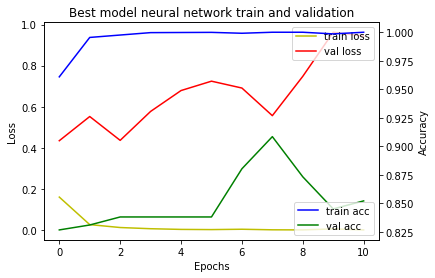

learning rate: 5.4e-07
num_dense_layers: 1
num_dense_nodes: 1024
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 70s 78ms/step - loss: 0.8473 - acc: 0.7513 - val_loss: 0.7536 - val_acc: 0.7600

Accuracy: 76.00%



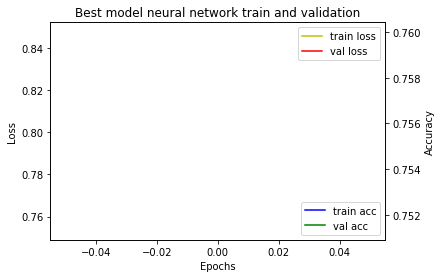

learning rate: 1.1e-06
num_dense_layers: 3
num_dense_nodes: 1024
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 72s 80ms/step - loss: 0.7410 - acc: 0.8383 - val_loss: 0.5048 - val_acc: 0.8733

Accuracy: 87.33%



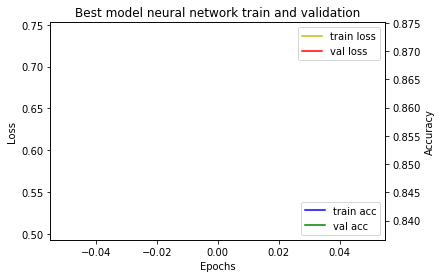

learning rate: 1.1e-06
num_dense_layers: 3
num_dense_nodes: 5
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 57s 64ms/step - loss: 1.1008 - acc: 0.3332 - val_loss: 1.0781 - val_acc: 0.4867

Accuracy: 48.67%



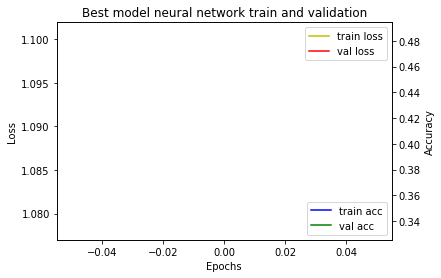

learning rate: 4.7e-06
num_dense_layers: 3
num_dense_nodes: 611
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 66s 73ms/step - loss: 0.4477 - acc: 0.8999 - val_loss: 0.3618 - val_acc: 0.8200

Accuracy: 82.00%



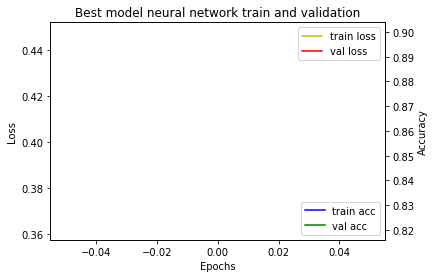

learning rate: 1.6e-04
num_dense_layers: 3
num_dense_nodes: 21
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 57s 64ms/step - loss: 0.3815 - acc: 0.8721 - val_loss: 0.5759 - val_acc: 0.8400
Epoch 2/20
900/900 [==============================] - 57s 64ms/step - loss: 0.0351 - acc: 0.9937 - val_loss: 0.6752 - val_acc: 0.8521
Epoch 3/20
900/900 [==============================] - 57s 64ms/step - loss: 0.0157 - acc: 0.9962 - val_loss: 0.8846 - val_acc: 0.8732
Epoch 4/20
900/900 [==============================] - 57s 64ms/step - loss: 0.0091 - acc: 0.9983 - val_loss: 0.6915 - val_acc: 0.8310
Epoch 5/20
900/900 [==============================] - 57s 64ms/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.9200 - val_acc: 0.8380
Epoch 6/20
900/900 [==============================] - 57s 64ms/step - loss: 0.0093 - acc: 0.9976 - val_loss: 0.8566 - val_acc: 0.8169
Epoch 7/20
900/900 [==============================] - 57s 64ms/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.7397 - 

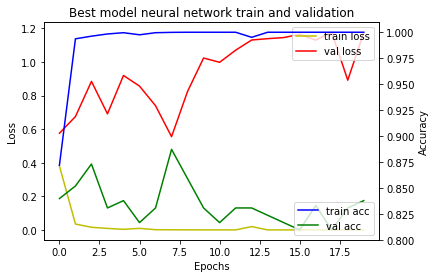

learning rate: 1.0e-07
num_dense_layers: 3
num_dense_nodes: 480
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 63s 70ms/step - loss: 1.0765 - acc: 0.4496 - val_loss: 1.0396 - val_acc: 0.5400
Epoch 2/20
900/900 [==============================] - 63s 70ms/step - loss: 1.0102 - acc: 0.6853 - val_loss: 0.9889 - val_acc: 0.6901
Epoch 3/20
900/900 [==============================] - 63s 70ms/step - loss: 0.9577 - acc: 0.7592 - val_loss: 0.9252 - val_acc: 0.7535
Epoch 4/20
900/900 [==============================] - 63s 70ms/step - loss: 0.9110 - acc: 0.8049 - val_loss: 0.8878 - val_acc: 0.8028
Epoch 5/20
900/900 [==============================] - 63s 70ms/step - loss: 0.8646 - acc: 0.8334 - val_loss: 0.8577 - val_acc: 0.7887
Epoch 6/20
900/900 [==============================] - 63s 70ms/step - loss: 0.8219 - acc: 0.8593 - val_loss: 0.7980 - val_acc: 0.8099
Epoch 7/20
900/900 [==============================] - 63s 70ms/step - loss: 0.7829 - acc: 0.8734 - val_loss: 0.7599 -

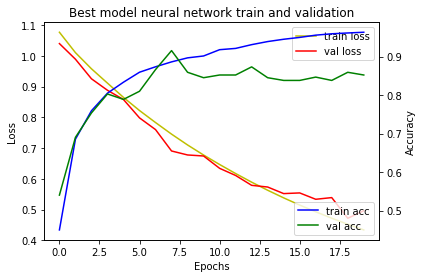

learning rate: 1.0e-07
num_dense_layers: 2
num_dense_nodes: 496
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 63s 70ms/step - loss: 1.0422 - acc: 0.5312 - val_loss: 1.0148 - val_acc: 0.5333
Epoch 2/20
900/900 [==============================] - 63s 70ms/step - loss: 0.9638 - acc: 0.7370 - val_loss: 0.9571 - val_acc: 0.7254
Epoch 3/20
900/900 [==============================] - 63s 70ms/step - loss: 0.9006 - acc: 0.8054 - val_loss: 0.8703 - val_acc: 0.8380
Epoch 4/20
900/900 [==============================] - 63s 70ms/step - loss: 0.8458 - acc: 0.8463 - val_loss: 0.8464 - val_acc: 0.8310
Epoch 5/20
900/900 [==============================] - 63s 70ms/step - loss: 0.7981 - acc: 0.8638 - val_loss: 0.8204 - val_acc: 0.8099
Epoch 6/20
900/900 [==============================] - 63s 70ms/step - loss: 0.7552 - acc: 0.8800 - val_loss: 0.7569 - val_acc: 0.8380
Epoch 7/20
900/900 [==============================] - 63s 70ms/step - loss: 0.7168 - acc: 0.8937 - val_loss: 0.7328 -

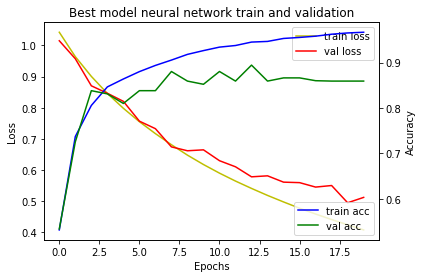

learning rate: 2.0e-05
num_dense_layers: 3
num_dense_nodes: 37
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 58s 64ms/step - loss: 0.4747 - acc: 0.9008 - val_loss: 0.3662 - val_acc: 0.8333
Epoch 2/20
900/900 [==============================] - 57s 64ms/step - loss: 0.1125 - acc: 0.9869 - val_loss: 0.3795 - val_acc: 0.8099
Epoch 3/20
900/900 [==============================] - 58s 65ms/step - loss: 0.0500 - acc: 0.9931 - val_loss: 0.2856 - val_acc: 0.8592
Epoch 4/20
900/900 [==============================] - 58s 64ms/step - loss: 0.0290 - acc: 0.9949 - val_loss: 0.3762 - val_acc: 0.8662
Epoch 5/20
900/900 [==============================] - 58s 65ms/step - loss: 0.0192 - acc: 0.9966 - val_loss: 0.4161 - val_acc: 0.8380
Epoch 6/20
900/900 [==============================] - 58s 65ms/step - loss: 0.0141 - acc: 0.9976 - val_loss: 0.4480 - val_acc: 0.8169
Epoch 7/20
900/900 [==============================] - 58s 65ms/step - loss: 0.0090 - acc: 0.9990 - val_loss: 0.4068 - 

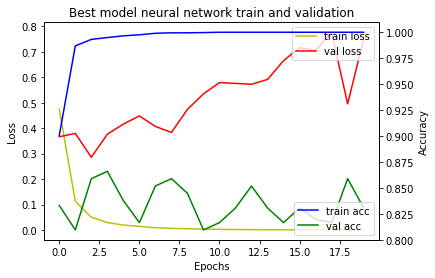

learning rate: 5.7e-07
num_dense_layers: 1
num_dense_nodes: 488
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 63s 70ms/step - loss: 0.8939 - acc: 0.6969 - val_loss: 0.7520 - val_acc: 0.7800
Epoch 2/20
900/900 [==============================] - 62s 69ms/step - loss: 0.6384 - acc: 0.9034 - val_loss: 0.6760 - val_acc: 0.7817
Epoch 3/20
900/900 [==============================] - 62s 69ms/step - loss: 0.4985 - acc: 0.9508 - val_loss: 0.5401 - val_acc: 0.8310
Epoch 4/20
900/900 [==============================] - 62s 69ms/step - loss: 0.4047 - acc: 0.9643 - val_loss: 0.4933 - val_acc: 0.8380
Epoch 5/20
900/900 [==============================] - 62s 69ms/step - loss: 0.3361 - acc: 0.9724 - val_loss: 0.4868 - val_acc: 0.8169
Epoch 6/20
900/900 [==============================] - 62s 69ms/step - loss: 0.2835 - acc: 0.9758 - val_loss: 0.4449 - val_acc: 0.8239
Epoch 7/20
900/900 [==============================] - 62s 69ms/step - loss: 0.2426 - acc: 0.9799 - val_loss: 0.4121 -

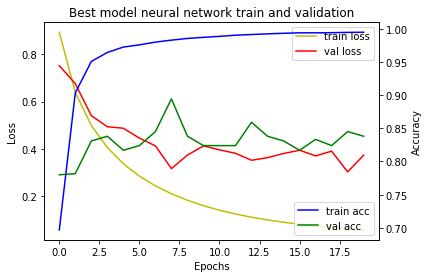

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 1024
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 70s 78ms/step - loss: 10.7359 - acc: 0.3333 - val_loss: 8.2740 - val_acc: 0.4867
Epoch 2/20
900/900 [==============================] - 70s 77ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 3/20
900/900 [==============================] - 70s 77ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 4/20
900/900 [==============================] - 70s 77ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 5/20
900/900 [==============================] - 70s 77ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 6/20
900/900 [==============================] - 70s 77ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 7/20
900/900 [==============================] - 70s 77ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 

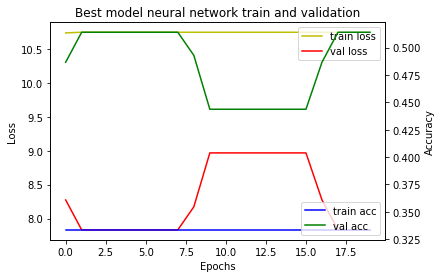

learning rate: 3.3e-05
num_dense_layers: 1
num_dense_nodes: 334
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 61s 67ms/step - loss: 0.2104 - acc: 0.9446 - val_loss: 0.3945 - val_acc: 0.8333
Epoch 2/20
900/900 [==============================] - 60s 67ms/step - loss: 0.0376 - acc: 0.9941 - val_loss: 0.4176 - val_acc: 0.8310
Epoch 3/20
900/900 [==============================] - 60s 67ms/step - loss: 0.0186 - acc: 0.9964 - val_loss: 0.3660 - val_acc: 0.8451
Epoch 4/20
900/900 [==============================] - 60s 67ms/step - loss: 0.0107 - acc: 0.9988 - val_loss: 0.4890 - val_acc: 0.8521
Epoch 5/20
900/900 [==============================] - 60s 67ms/step - loss: 0.0065 - acc: 0.9990 - val_loss: 0.5550 - val_acc: 0.8099
Epoch 6/20
900/900 [==============================] - 60s 67ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.5748 - val_acc: 0.8099
Epoch 7/20
900/900 [==============================] - 60s 67ms/step - loss: 0.0047 - acc: 0.9989 - val_loss: 0.5568 -

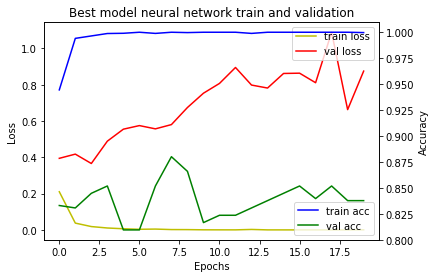

learning rate: 2.6e-05
num_dense_layers: 3
num_dense_nodes: 671
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 66s 74ms/step - loss: 0.1594 - acc: 0.9529 - val_loss: 0.4469 - val_acc: 0.8333
Epoch 2/20
900/900 [==============================] - 66s 73ms/step - loss: 0.0246 - acc: 0.9919 - val_loss: 0.6454 - val_acc: 0.8169
Epoch 3/20
900/900 [==============================] - 66s 73ms/step - loss: 0.0121 - acc: 0.9968 - val_loss: 0.4593 - val_acc: 0.8380
Epoch 4/20
900/900 [==============================] - 66s 73ms/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.7661 - val_acc: 0.8310
Epoch 5/20
900/900 [==============================] - 66s 73ms/step - loss: 0.0148 - acc: 0.9953 - val_loss: 0.8390 - val_acc: 0.8521
Epoch 6/20
900/900 [==============================] - 66s 73ms/step - loss: 0.0059 - acc: 0.9978 - val_loss: 0.6938 - val_acc: 0.8451
Epoch 7/20
900/900 [==============================] - 66s 73ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.6081 -

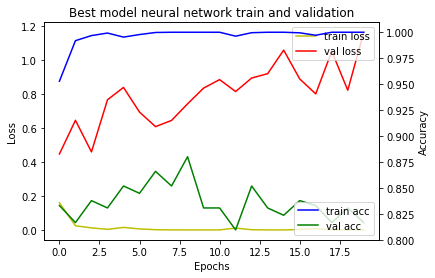

learning rate: 2.2e-04
num_dense_layers: 1
num_dense_nodes: 1024
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 70s 78ms/step - loss: 0.1479 - acc: 0.9592 - val_loss: 0.5373 - val_acc: 0.8600

Accuracy: 86.00%



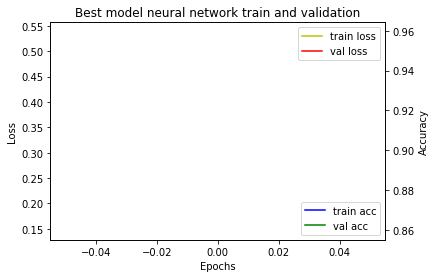

learning rate: 1.0e-07
num_dense_layers: 1
num_dense_nodes: 545
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 63s 70ms/step - loss: 1.0590 - acc: 0.4930 - val_loss: 0.9963 - val_acc: 0.6667

Accuracy: 66.67%



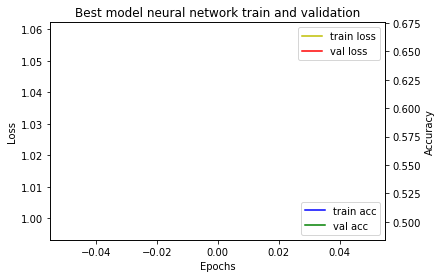

learning rate: 1.0e-07
num_dense_layers: 2
num_dense_nodes: 1024
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 71s 79ms/step - loss: 1.0691 - acc: 0.5158 - val_loss: 1.0207 - val_acc: 0.5267
Epoch 2/20
900/900 [==============================] - 71s 78ms/step - loss: 0.9344 - acc: 0.7664 - val_loss: 0.9354 - val_acc: 0.6901
Epoch 3/20
900/900 [==============================] - 71s 78ms/step - loss: 0.8509 - acc: 0.8422 - val_loss: 0.8434 - val_acc: 0.7535
Epoch 4/20
900/900 [==============================] - 70s 78ms/step - loss: 0.7816 - acc: 0.8791 - val_loss: 0.7981 - val_acc: 0.7958
Epoch 5/20
900/900 [==============================] - 70s 78ms/step - loss: 0.7216 - acc: 0.9052 - val_loss: 0.7667 - val_acc: 0.8169
Epoch 6/20
900/900 [==============================] - 70s 78ms/step - loss: 0.6696 - acc: 0.9187 - val_loss: 0.6987 - val_acc: 0.8239
Epoch 7/20
900/900 [==============================] - 70s 78ms/step - loss: 0.6241 - acc: 0.9317 - val_loss: 0.6626 

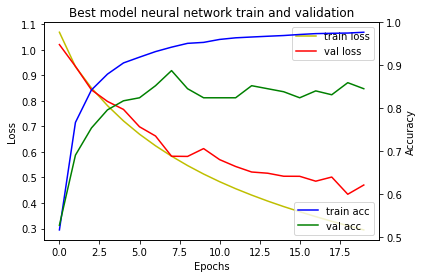

learning rate: 8.1e-06
num_dense_layers: 1
num_dense_nodes: 264
num_epoch: 10

Epoch 1/10
900/900 [==============================] - 60s 66ms/step - loss: 0.4288 - acc: 0.9059 - val_loss: 0.4015 - val_acc: 0.8467
Epoch 2/10
900/900 [==============================] - 60s 66ms/step - loss: 0.1342 - acc: 0.9883 - val_loss: 0.3969 - val_acc: 0.8451
Epoch 3/10
900/900 [==============================] - 60s 66ms/step - loss: 0.0714 - acc: 0.9936 - val_loss: 0.3103 - val_acc: 0.8380
Epoch 4/10
900/900 [==============================] - 60s 66ms/step - loss: 0.0440 - acc: 0.9958 - val_loss: 0.4036 - val_acc: 0.8451
Epoch 5/10
900/900 [==============================] - 60s 66ms/step - loss: 0.0305 - acc: 0.9962 - val_loss: 0.4450 - val_acc: 0.8451
Epoch 6/10
900/900 [==============================] - 60s 66ms/step - loss: 0.0221 - acc: 0.9971 - val_loss: 0.4382 - val_acc: 0.8380
Epoch 7/10
900/900 [==============================] - 60s 66ms/step - loss: 0.0165 - acc: 0.9984 - val_loss: 0.4141 -

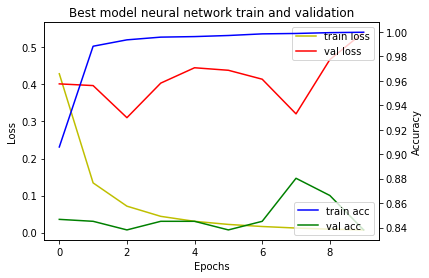

learning rate: 1.0e-02
num_dense_layers: 3
num_dense_nodes: 1024
num_epoch: 18

Epoch 1/18
900/900 [==============================] - 72s 80ms/step - loss: 10.7376 - acc: 0.3332 - val_loss: 13.9690 - val_acc: 0.1333
Epoch 2/18
900/900 [==============================] - 71s 79ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 3/18
900/900 [==============================] - 71s 79ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 4/18
900/900 [==============================] - 71s 79ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 5/18
900/900 [==============================] - 71s 79ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 6/18
900/900 [==============================] - 71s 79ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 13.8479 - val_acc: 0.1408
Epoch 7/18
900/900 [==============================] - 71s 79ms/step - loss: 10.7454 - acc: 0.3333 - val_

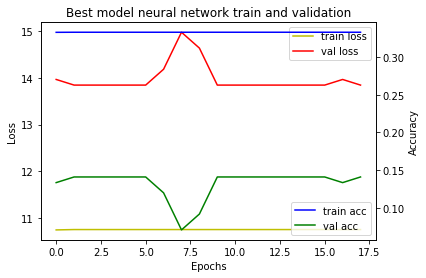

learning rate: 1.5e-04
num_dense_layers: 1
num_dense_nodes: 5
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 57s 63ms/step - loss: 0.4884 - acc: 0.8098 - val_loss: 0.3217 - val_acc: 0.8867
Epoch 2/20
900/900 [==============================] - 57s 63ms/step - loss: 0.1753 - acc: 0.9769 - val_loss: 0.2834 - val_acc: 0.8521
Epoch 3/20
900/900 [==============================] - 57s 63ms/step - loss: 0.0875 - acc: 0.9867 - val_loss: 0.2291 - val_acc: 0.8803
Epoch 4/20
900/900 [==============================] - 57s 63ms/step - loss: 0.0523 - acc: 0.9922 - val_loss: 0.3104 - val_acc: 0.8521
Epoch 5/20
900/900 [==============================] - 57s 63ms/step - loss: 0.0362 - acc: 0.9948 - val_loss: 0.3628 - val_acc: 0.8521
Epoch 6/20
900/900 [==============================] - 57s 63ms/step - loss: 0.0265 - acc: 0.9957 - val_loss: 0.3746 - val_acc: 0.8310
Epoch 7/20
900/900 [==============================] - 57s 63ms/step - loss: 0.0197 - acc: 0.9964 - val_loss: 0.3572 - v

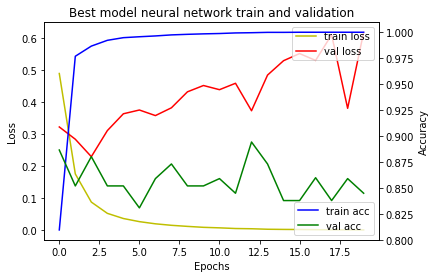

learning rate: 1.1e-04
num_dense_layers: 2
num_dense_nodes: 1024
num_epoch: 1

Epoch 1/1
900/900 [==============================] - 71s 79ms/step - loss: 0.1251 - acc: 0.9558 - val_loss: 0.6764 - val_acc: 0.8200

Accuracy: 82.00%



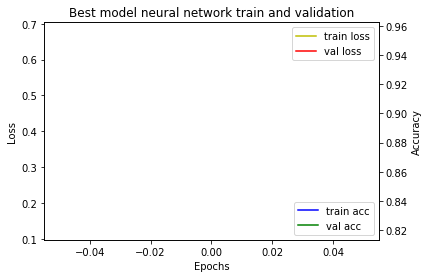

learning rate: 2.1e-07
num_dense_layers: 2
num_dense_nodes: 735
num_epoch: 20

Epoch 1/20
900/900 [==============================] - 67s 74ms/step - loss: 0.9945 - acc: 0.6258 - val_loss: 0.9232 - val_acc: 0.7400
Epoch 2/20
900/900 [==============================] - 67s 74ms/step - loss: 0.8391 - acc: 0.8336 - val_loss: 0.8157 - val_acc: 0.8099
Epoch 3/20
900/900 [==============================] - 67s 74ms/step - loss: 0.7233 - acc: 0.8953 - val_loss: 0.6887 - val_acc: 0.8451
Epoch 4/20
900/900 [==============================] - 67s 74ms/step - loss: 0.6366 - acc: 0.9211 - val_loss: 0.6497 - val_acc: 0.8451
Epoch 5/20
900/900 [==============================] - 67s 74ms/step - loss: 0.5679 - acc: 0.9420 - val_loss: 0.5947 - val_acc: 0.8239
Epoch 6/20
900/900 [==============================] - 67s 74ms/step - loss: 0.5111 - acc: 0.9513 - val_loss: 0.5542 - val_acc: 0.8451
Epoch 7/20
900/900 [==============================] - 67s 74ms/step - loss: 0.4609 - acc: 0.9609 - val_loss: 0.5289 -

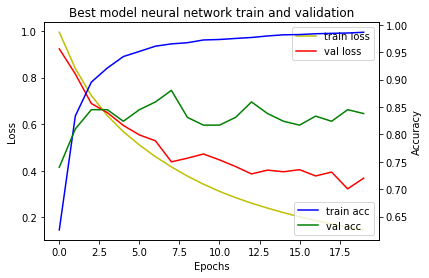

learning rate: 7.6e-05
num_dense_layers: 2
num_dense_nodes: 5
num_epoch: 12

Epoch 1/12
900/900 [==============================] - 57s 64ms/step - loss: 0.7097 - acc: 0.6181 - val_loss: 0.6441 - val_acc: 0.5133
Epoch 2/12
900/900 [==============================] - 57s 63ms/step - loss: 0.5120 - acc: 0.6619 - val_loss: 0.5373 - val_acc: 0.5634
Epoch 3/12
900/900 [==============================] - 57s 63ms/step - loss: 0.3821 - acc: 0.8056 - val_loss: 0.3072 - val_acc: 0.9014
Epoch 4/12
900/900 [==============================] - 57s 63ms/step - loss: 0.1722 - acc: 0.9804 - val_loss: 0.2602 - val_acc: 0.8803
Epoch 5/12
900/900 [==============================] - 57s 63ms/step - loss: 0.0845 - acc: 0.9904 - val_loss: 0.2765 - val_acc: 0.8662
Epoch 6/12
900/900 [==============================] - 57s 63ms/step - loss: 0.0526 - acc: 0.9923 - val_loss: 0.3013 - val_acc: 0.8380
Epoch 7/12
900/900 [==============================] - 57s 63ms/step - loss: 0.0376 - acc: 0.9944 - val_loss: 0.2783 - v

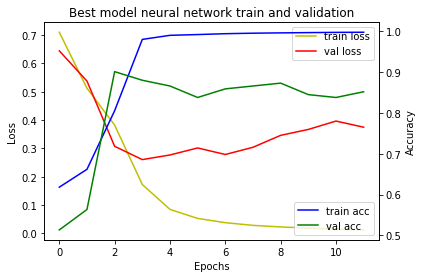

Wall time: 7h 53min 1s


In [62]:
%%time
search_result = gp_minimize(func=fitness, dimensions=dimensions, acq_func='EI', n_calls=40, x0=default_parameters)

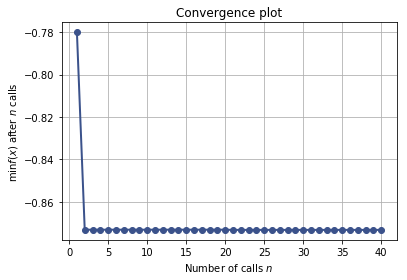

In [63]:
plot_convergence(search_result)

In [64]:
search_result.x

[1.1272675150868611e-06, 3, 1024, 1]

In [65]:
search_result.fun

-0.87333333094914756

In [66]:
new_model = load_model(path_best_model)

In [67]:
generator_test.reset()
result = new_model.evaluate_generator(generator_test)

In [68]:
for name, value in zip(new_model.metrics_names, result):
  print(name, value)

loss 0.499453740685
acc 0.874999997647


In [69]:
result

[0.49945374068460968, 0.87499999764718506]

여기까지가 GP를 이용한 Bayesian-optimizer method

In [70]:
class_name = generator_train.class_indices.keys()

In [71]:
train_dir = './aug_train1'
test_dir = './valid1'


In [72]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [73]:
len(generator_train.filenames)
len(generator_test.filenames)

152

In [74]:

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [75]:

cls_train = generator_train.classes
cls_test = generator_test.classes

In [84]:
class_names = os.listdir('./aug_train1')
class_names

['1gr', '2gr', '3gr']

In [85]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [86]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    re = classification_report(y_true=cls_test,
                               y_pred=cls_pred)
    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    print(re)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [87]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [88]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [89]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

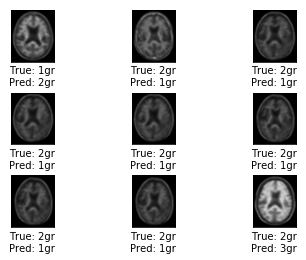

Confusion matrix:
[[72  1  0]
 [10  7  3]
 [ 0  5 54]]
             precision    recall  f1-score   support

          0       0.88      0.99      0.93        73
          1       0.54      0.35      0.42        20
          2       0.95      0.92      0.93        59

avg / total       0.86      0.88      0.86       152

(0) 1gr
(1) 2gr
(2) 3gr


In [90]:
example_errors()